In [1]:
import os
import time
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.3.0-dev20200523


In [3]:
NUM_GPUS = 1
BS_PER_GPU = 64
NUM_EPOCHS = 50

HEIGHT = 150
WIDTH = 150
NUM_CHANNELS = 3

batch_size = 32
num_epochs = 50
num_classes = 1000
image_size = (150, 150)

## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [4]:
dataTrainDir = '/data/datasets/imagenet/raw/train'
dataValDir = '/data/datasets/imagenet/raw/validation'

resultsDir = 'results'
modelsDir = 'models/imagenet_xception'
logsDir = 'logs/imagenet_xception'

In [5]:
if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

if not os.path.exists(modelsDir):
    os.mkdir(modelsDir)
        
if not os.path.exists(logsDir):
    os.mkdir(logsDir)

## Generate dataset

In [6]:
train_class = next(os.walk(dataTrainDir))[1]
train_class.sort()
print("Number of folders in TrainDir: {}".format(len(train_class)))

val_class = next(os.walk(dataValDir))[1]
val_class.sort()
print("Number of folders in ValDir: {}".format(len(val_class)))

Number of folders in TrainDir: 1000
Number of folders in ValDir: 1000


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataTrainDir,
    labels='inferred',
    class_names=train_class,
    seed=1337,
    image_size=image_size,
    batch_size=BS_PER_GPU,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataValDir,
    labels='inferred',
    class_names=val_class,
    seed=1337,
    image_size=image_size,
    batch_size=BS_PER_GPU,
)

Found 1281167 files belonging to 1000 classes.
Found 50000 files belonging to 1000 classes.


In [8]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))

tf.Tensor(20019, shape=(), dtype=int64)
tf.Tensor(782, shape=(), dtype=int64)


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".


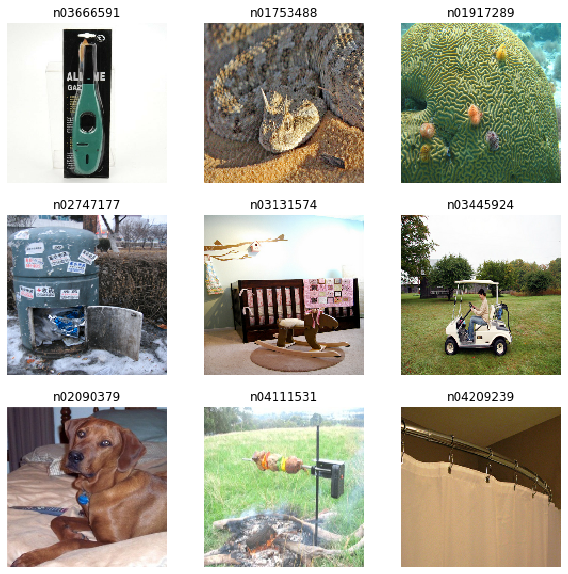

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class[int(labels[i])])
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

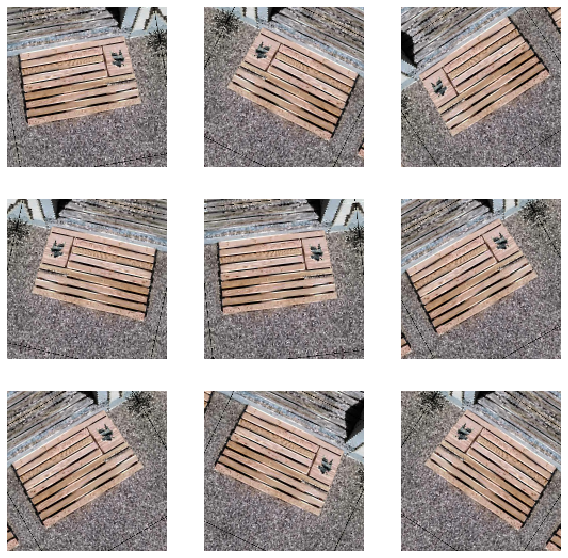

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

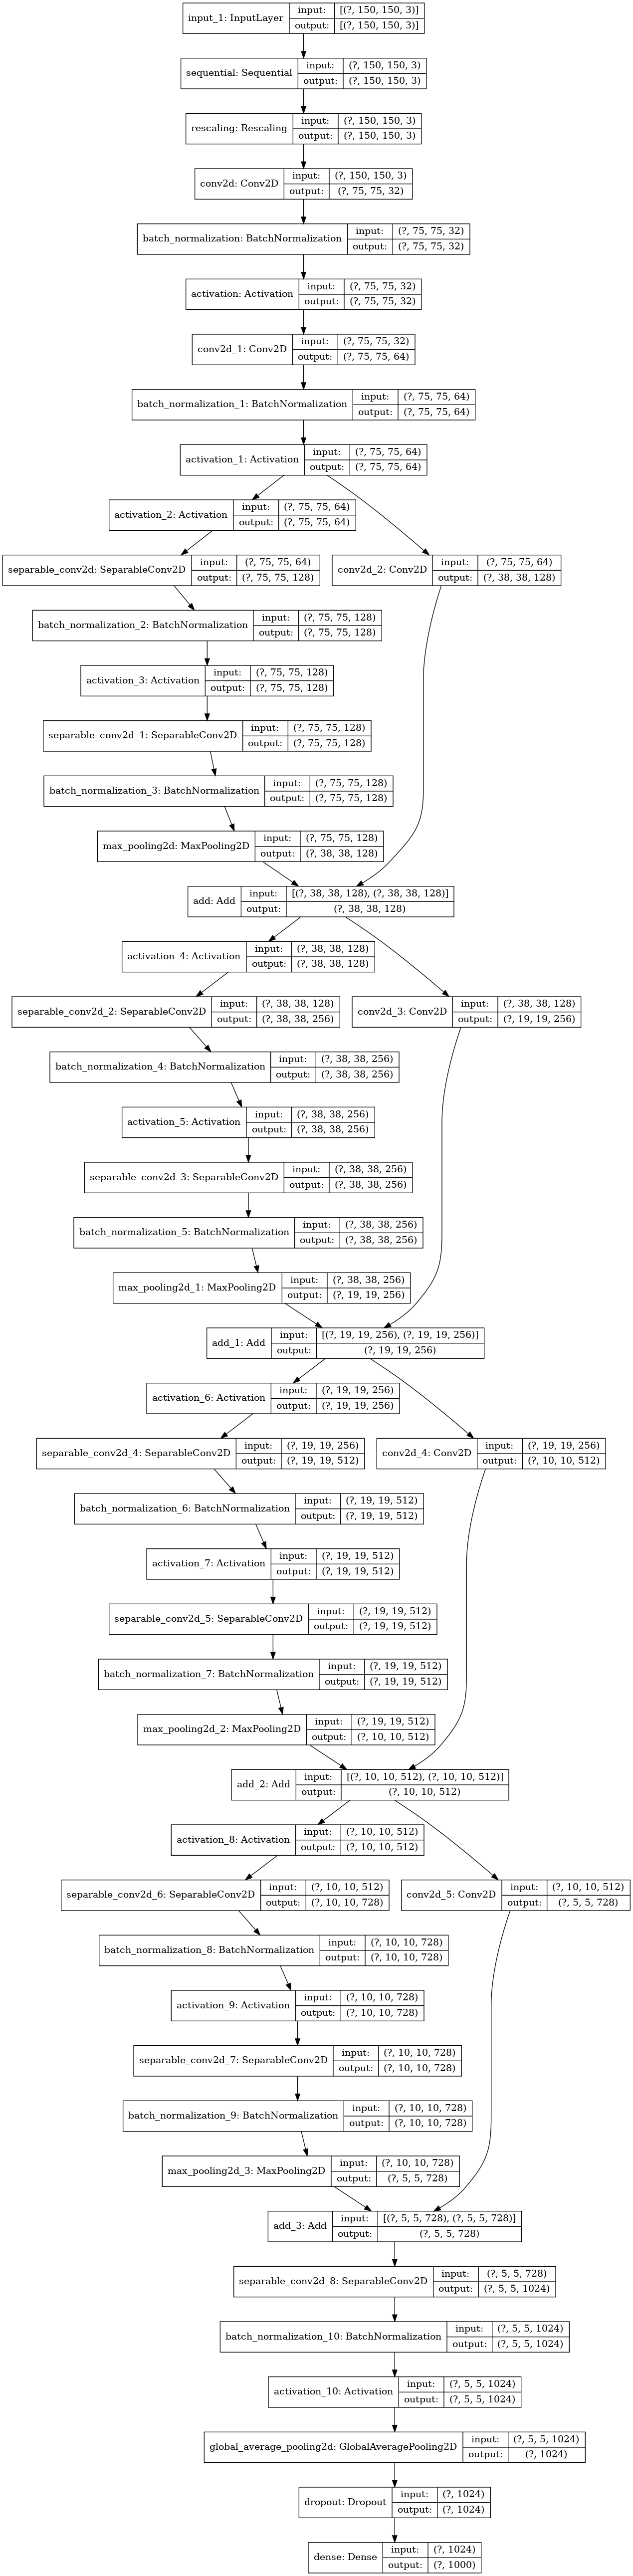

In [14]:
modelDiagramFile = os.path.join(resultsDir, 'model_imagenet_Xception.png')

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)

## Train the model

In [15]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5")),
    keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1),
]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

startTime = time.time()

model.fit(train_ds,
          epochs=num_epochs,
          callbacks=callbacks,
          validation_data=val_ds,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Epoch 1/50
    1/20019 [..............................] - ETA: 8s - loss: 7.0302 - sparse_categorical_accuracy: 0.0000e+00WARNING:tensorflow:From /data/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20019/20019 [==============================] - 9813s 490ms/step - loss: 4.5883 - sparse_categorical_accuracy: 0.1440 - val_loss: 3.8498 - val_sparse_categorical_accuracy: 0.2245
Epoch 2/50
 8314/20019 [===========>..................] - ETA: 1:17:16 - loss: 3.4347 - sparse_categorical_accuracy: 0.2818

KeyboardInterrupt: 

In [ ]:
modelFile = os.path.join(modelsDir, 'model_best.h5')

model.save(modelFile)

## Evaluate model

In [ ]:
import numpy as np
import requests

In [ ]:
model = keras.models.load_model(modelFile)

In [ ]:
def predict_url(url):
    response = requests.get(url, stream=True)
    image = tf.image.decode_jpeg(response.content)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    image = tf.expand_dims(image, 0)
    
    y_prob = model.predict(image)
    print(y_prob)
    y_classes = y_prob.argmax(axis=-1)
    
    if y_classes == 0:
        print("Predicción del modelo: Gato")
    elif y_classes == 1:
        print("Predicción del modelo: Perro")

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"
predict_url(url)

In [ ]:
url="https://s3-eu-west-1.amazonaws.com/barkibu-blog/blog+images/mi-perro-tiene-hipo-muy-seguido-que-le-pasa/perro-hipo-1.jpg"
predict_url(url)